In [23]:
import numpy as np;from scipy import signal;from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py;import json
import matplotlib.pyplot as plt;import matplotlib.mlab as mlab 
import readligo as rl
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

## Load LIGO data.

In [2]:
eventname = 'GW150914'
plottype = "png"

# Read the event properties from a local json file
fnjson = "BBH_events_v3.json"
try:
    events = json.load(open(fnjson,"r"))
except IOError:
    print("Cannot find resource file "+fnjson)

# Extract the parameters for the desired event:
event = events[eventname]
fn_H1 = event['fn_H1']              # File name for H1 data
fn_L1 = event['fn_L1']              # File name for L1 data
fn_template = event['fn_template']  # File name for template waveform
fs = event['fs']                    # Set sampling rate
tevent = event['tevent']            # Set approximate event GPS time
fband = event['fband']              # frequency band for bandpassing signal

try:
    # read in data from H1 and L1, if available:
    strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
    strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
except:
    print("Cannot find data files!")

In [3]:
# both H1 and L1 will have the same time vector, so:
time = time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

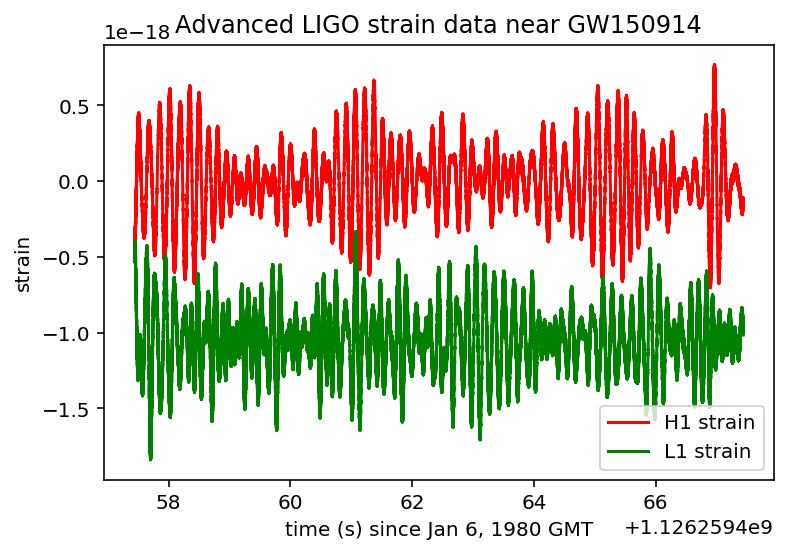

In [4]:
# plot +- deltat seconds around the event:
deltat = 5
# index into the strain time series for this time interval:
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat)) 
plt.figure()
plt.plot(time[indxt],strain_H1[indxt],'r',label='H1 strain')
plt.plot(time[indxt],strain_L1[indxt],'g',label='L1 strain')
plt.xlabel('time (s) since Jan 6, 1980 GMT');plt.ylabel('strain')
plt.legend(loc='lower right');plt.title('Advanced LIGO strain data near '+eventname)
plt.show()

# Load Template

In [5]:
# Read in the template (plus and cross polarizations of the wave)
try:
    f_template = h5py.File(fn_template, "r")
except:
    print("Cannot find template file!")
    
template_p, template_c = f_template["template"][...]
t_approx = f_template["/meta"].attrs['approx']
f_template.close()

# The template only lasts approx. 16s, but is zero-padded to the 32s data length.
template_offset = 16.

## NOTE:
Fourier transform normalizations:

\begin{equation}
    \tilde{x}[k] = \Delta t\sum_{j=0}^{N-1} x[j]\ e^{-\frac{2\pi ijk}{N}}
\end{equation}
\begin{equation}
    x[j] = \Delta f\sum_{k=0}^{N-1} \tilde{x}[k]\ e^{\frac{2\pi ijk}{N}}
\end{equation}
Where $\Delta f = \frac{1}{N\Delta t}$. This is the normaliztion suggested by the LIGO team.

## Power Spectral density calculator

In [6]:
NFFT = 4*fs
PSD_WINDOW = np.hanning(NFFT)
NOVL = 0

def PSD(S):
    return signal.welch(S, fs = fs, nfft = NFFT, window=PSD_WINDOW, noverlap=NOVL)

In [27]:
dt = 1/fs

In [13]:
# Template preparation
template = (template_p + template_c*1.j) 
# Plus and cross polarizations of the wave encoded as real and imaginary parts of template.

In [14]:
datafreq = np.fft.fftfreq(template.size)*fs
freqs,data_psd = PSD(strain_H1)

In [15]:
window = signal.tukey(template.size, alpha=1./8)
df = np.abs(datafreq[1] - datafreq[0])

In [16]:
# Take the Fourier Transform (FFT) of the data and the template (with window)
template_fft = np.fft.fft(template*window)*dt
data_fft = np.fft.fft(strain_H1*window)*dt

# Get the Power Spectral Density values at the needed frequencies (datafreq)
S_n = np.interp(np.abs(datafreq), freqs, data_psd)

# Matched filter implimentation

We pass our signal s(t) through a filter with with impulse response $h(t)$, the output is:
\begin{equation}
    y(\tau) = \int_{-\infty}^{\infty} s(\tau-t) h(t) dt
\end{equation}

We have a template which represents the ideal gravitational wave signal, and we want to find where in the signal the template waveform lies (if it even does!).  

If we chose $h(t)$ to equal our template waveform, the filter will have the hightest possible signal to noise ratio when the data follows the template. This gives us the best way of finding a known signal buried in noise.

The matched filter calculation is a convolution, which can be simplified using the fourier transform. The matched filter can ultma be expressed as:
\begin{equation}
    m(t) = 2\int_{-\infty}^{\infty} \frac{\tilde{s}(f)\tilde{h}(f)^*}{S_n(f)}e^{2\pi ift} df
\end{equation}

Where $\tilde{s}(f)$ and $\tilde{h}(f)$ are the fourier transforms of the signal and template waveforms, respectively, and $S_n(f)$ is the spectral power density of the signal.

In [34]:
internal = (data_fft * template_fft.conjugate()) / S_n
m = 2*np.fft.ifft(internal)/dt

Since the noise is stationary (uncorrelated?) the noise variance is given by:
\begin{equation}
    \sigma_m^2 = \int_{-\infty}^{\infty} \frac{|\tilde{h}(f)|^2}{S_n(f)} df
\end{equation}

In [33]:
variance = (template_fft * template_fft.conjugate() / S_n).sum() * df
sigma = np.sqrt(np.abs(variance))

The amplitude signal to noise ratio is defined as:
\begin{equation}
\rho(t) = \frac{|m(t)|}{\sigma_m}
\end{equation}

In [35]:
m_sigma = m/sigma
SNR = np.abs(m_sigma)

## Find the max SNR

In [29]:
max_SNR_index = np.where(SNR == max(SNR))

In [30]:
t_ = time[max_SNR_index]

In [32]:
t_[0]

1126259446.4394531

In [50]:
# shift the SNR vector by the template length so that the peak is at the END of the template
peaksample = int(data.size / 2)  # location of peak in the template
SNR_complex = np.roll(SNR_complex,peaksample)
SNR = abs(SNR_complex)

# find the time and SNR value at maximum:
indmax = np.argmax(SNR)
timemax = time[indmax]
SNRmax = SNR[indmax]

# Extract time offset and phase at peak
phase = np.angle(SNR_complex[indmax])
offset = (indmax-peaksample)

# apply time offset, phase, and d_eff to template 
template_phaseshifted = np.real(template*np.exp(1j*phase))    # phase shift the template
template_rolled = np.roll(template_phaseshifted,offset) / d_eff  # Apply time offset and scale amplitude

# Whiten and band-pass the template for plotting
template_whitened = whiten(template_rolled,interp1d(freqs, data_psd),dt)  # whiten the template
template_match = filtfilt(bb, ab, template_whitened) / normalization # Band-pass the template

NameError: name 'data' is not defined